In [5]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Análisis exploratorio de las cartas a los accionistas

En primer lugar se cargan los datos. Se tiene un total de 42 cartas a los accionistas, obtenidas de las memorias corporativas del año 2020. 

Las variables que se utilizarán son:
- nombre: nombre de la empresa.
- industria: sector económico en el que opera la empresa.
- cargo: puesto de quien escribe la carta a los accionistas. Generalmente se detara del 'Presidente del directorio', pero en algunos casos también escribe el 'Gerente general'
- carta: texto de la carta a los accionistas.

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/publicaciones/main/econ-sent-class/cartas_accionistas.csv')
data = data[['nombre', 'industria', 'cargo', 'carta']]
print(data.shape)
data.head()

(42, 4)


,nombre,industria,cargo,carta
0,AES Gener,Energía,Presidente del Directorio y Gerente General,La gestión oportuna de los impactos de la pand...
1,Aguas Andinas,Servicios Básicos,Presidente del Directorio,"Como cada año, tengo el agrado de presentarles..."
2,Aguas Andinas,Servicios Básicos,Gerente General,"""Sin duda, la pandemia por Covid-19 marcó nues..."
3,Banco de Chile,Financiera,Presidente del Directorio,Con gran orgullo y satisfacción me dirijo a us...
4,Banco de Chile,Financiera,Gerente General,"""Me siento muy honrado de compartir con ustede..."


A continuación se muestra la lista de industrias y empresas.
- El código de la primera línea crea un dataframe que contiene sólo los nombres de industria y empresa, y elimina las observaciones duplicadas (caso en que se tiene más de una carta, del presidente del directorio y gerente general).
- Luego se muestran dos cuadros: (1) la cantidad de empresas por industria, y (2) lista de empresas por industria, ordenadas según industria.

In [7]:
# Lista de empresas e industrias
table1 = data[['industria', 'nombre']].drop_duplicates()
table1.to_csv('00_table1.csv', index=False, encoding='utf-8-sig')

display(table1['industria'].value_counts())
table1.sort_values('industria')

Comercio                   7
Financiera                 6
Energía                    4
Tecnología y Transporte    4
Servicios Básicos          3
Manufactura                3
Bebidas                    3
Name: industria, dtype: int64

,industria,nombre
19,Bebidas,Embotelladora Andina
9,Bebidas,CCU
16,Bebidas,Concha y Toro
38,Comercio,SMU
37,Comercio,Ripley
35,Comercio,Parque Arauco
33,Comercio,Mall Plaza
25,Comercio,Falabella
10,Comercio,Cencosud
12,Comercio,Cencosud Shopping


La siguiente celda muestra las empresas sin carta a los accionistas. 

In [8]:
# Empresas sin carta a los accionistas
data[data['carta'].isna()]

,nombre,industria,cargo,carta
41,SQM,Manufactura,NaN,NaN


Este dato se elimina de la base de datos y se resetea el índice.

In [9]:
# Se eliminan los datos perdidos
data = data.dropna().reset_index(drop=True)

A continuación se muestran los distintos cargos de quienes firman las cartas a los accionistas. Se observan cinco cargos o combinaciones de cargos (casos en que dos personas comparten la autoría de la carta).

In [10]:
data['cargo'].unique()

array(['Presidente del Directorio y Gerente General',
       'Presidente del Directorio', 'Gerente General',
       'Gerente General Corporativo', 'Vicepresidente Ejecutivo'],
      dtype=object)

El sigiuente cuadro muestra el número de cartas por 'cargo' e industria'.

In [11]:
table2 = pd.pivot_table(data, index='industria', columns='cargo', values='nombre', aggfunc='count', fill_value=0)
table2.to_csv('00_table2.csv', encoding='utf-8-sig')
table2

cargo,Gerente General,Gerente General Corporativo,Presidente del Directorio,Presidente del Directorio y Gerente General,Vicepresidente Ejecutivo
industria,,,,,
Bebidas,0,0,3,0,0
Comercio,4,1,7,0,1
Energía,1,0,2,2,0
Financiera,4,0,6,0,0
Manufactura,0,0,2,0,0
Servicios Básicos,1,0,2,1,0
Tecnología y Transporte,0,0,4,0,0


En la siguiente celda se simplifican los cargos anteriores agrupándolos en dos categorías: 'Gerente' y 'Presidente'.

In [13]:
data['autor'] = data['cargo']
data['autor'] = data['autor'].replace({
    'Gerente General': 'Gerente',
    'Gerente General Corporativo': 'Gerente',
    'Presidente del Directorio': 'Presidente',
    'Presidente del Directorio y Gerente General': 'Presidente',
    'Vicepresidente Ejecutivo': 'Gerente'
})

Nuevamente, se muestra el número de cartas por 'cargo' e industria'. Se observa que en el Comercio y sector Financiero es más común que los gerentes escriban cartas a los accionistas.

Las cartas más interesantes son las de los **presidentes de los directorios**, ya que en todas las empresas éstos escriben una carta, mientras que sólo en algunas escribe también el gerente general.

In [14]:
table3 = pd.pivot_table(data, index='industria', columns='autor', values='nombre', aggfunc='count', fill_value=0)
table3.to_csv('00_table3.csv', encoding='utf-8-sig')
table3

autor,Gerente,Presidente
industria,,
Bebidas,0,3
Comercio,6,7
Energía,1,4
Financiera,4,6
Manufactura,0,2
Servicios Básicos,1,3
Tecnología y Transporte,0,4


En la siguiente celda se carga una lista de **Stopwords**. Las StopWords son palabras sin un significado o sentido claro—como los artículos, pronombres y preposiciones—que se usan con frecuencia en todo tipo de textos, independientemente de la polaridad, por lo que no contribuyen a la clasificación de las cartas.

In [15]:
# Stopwords
sw = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/publicaciones/main/econ-sent-class/spanish.txt', header=None, names=['stopwords'])
stopwords = sw['stopwords'].tolist()

Se define una función para preprocesar los textos. Esta función:
- Pone todas las palabras en minúsculas.
- Quita números y caracteres especiales.
- Separa los textos en palabras individuales.
- Mantiene sólo las palabras que no sean Stopwords (remueve las Stopwords)
- Une las palabras nuevamente para formar un texto.

In [17]:
# Función para preprocesar los datos
def preprocess(s):
    s = s.lower()
    s = re.sub('[0-9]+', '', s) 
    s = re.sub('[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t—’‘“”]', '', s)
    tokens = nltk.tokenize.word_tokenize(s) 
    tokens = [t for t in tokens if t not in stopwords] 
    jtokens = ' '.join(tokens)
    return jtokens 

En la siguiente celda se aplica la función a las cartas a los accionistas escritas por los presidentes de los directorios, la variable de interés.

Luego se aplica la función **TfidfVectorizer**, que vectoriza las cartas, dándoles una estructura de dataframe (matricial), donde las cartas son las filas, y el *vocabulario* son las columnas. El vocabulario es una lista de todas las palabras presentes en el total de textos. Este vocabulario se compone de las 1000 palabras más frecuentes.

El valor corresponde a la medida **Tf-idf** (term frequency – Inverse document frequency), que multiplica la frecuencia con que cada palabra aparece por el inverso de la frecuencia con que aparece en el total de textos, lo que hace que las palabras muy comunes tengan un menor peso en la matriz.


In [19]:
presidentes = data[data['autor']=='Presidente']['carta']
pdata = [preprocess(t) for t in presidentes]

vect = TfidfVectorizer(max_features=1000,
                      strip_accents='unicode')
vdat = vect.fit_transform(pdata)
vdata = pd.DataFrame(vdat.toarray(), columns=vect.get_feature_names())
print(vdata.shape)
vdata.head()

(29, 1000)


,abastecimiento,abordar,acceder,acceso,accion,acciones,accionistas,aceleracion,acero,actividad,...,vez,vida,vio,virus,vision,vista,vivimos,volumen,volumenes,web
0,0.0,0.000000,0.000000,0.000000,0.0,0.041661,0.000000,0.000000,0.087748,0.000000,...,0.036046,0.000000,0.000000,0.0,0.000000,0.000000,0.055759,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.031715,0.000000,0.000000,0.000000,0.000000,...,0.082324,0.028428,0.000000,0.0,0.042448,0.000000,0.042448,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.0,0.020065,0.016766,0.000000,0.000000,0.000000,...,0.000000,0.017985,0.000000,0.0,0.000000,0.029711,0.000000,0.000000,0.000000,0.000000
3,0.0,0.048947,0.000000,0.000000,0.0,0.015629,0.013059,0.083482,0.000000,0.104591,...,0.013523,0.056037,0.000000,0.0,0.020918,0.069427,0.020918,0.027827,0.000000,0.000000
4,0.0,0.000000,0.019286,0.017312,0.0,0.012316,0.010291,0.021929,0.000000,0.000000,...,0.021313,0.000000,0.020497,0.0,0.000000,0.000000,0.000000,0.021929,0.021929,0.040994


Luego, se promedian los valores por columna y se muestran las palabras más y menos relevantes según esta medida.

In [20]:
mdata = vdata.mean(axis=0)
mdata = mdata.sort_values(ascending=False)
mdata = mdata.T

print('Palabras más relevantes: \n', mdata.head(10), '\n')
print('Palabras menos relevantes: \n', mdata.tail(10))

Palabras más relevantes: 
 ano              0.111728
clientes         0.086039
compania         0.071076
chile            0.062234
millones         0.057482
pandemia         0.052426
colaboradores    0.048266
parte            0.045352
pais             0.045138
empresas         0.044240
dtype: float64 

Palabras menos relevantes: 
 eje             0.005003
adicionales     0.004947
directores      0.004901
falta           0.004894
recien          0.004894
obtuvimos       0.004746
datos           0.004704
dado            0.004495
incorporando    0.004410
cumplimiento    0.003905
dtype: float64


La  siguiente nuble de palabras (wordcloud) es una representación gráfica de las palabras más importantes (según tf-idf). Se observan algunas palabras típicas de la jerga corporativa y otras relacionadas a la pandemia de covid19.

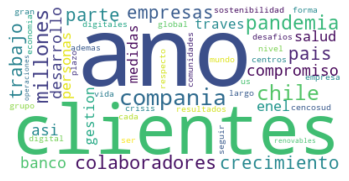

In [21]:
freqs = [(word, vdat.getcol(idx).sum()) for word, idx in vect.vocabulary_.items()]
freqs = dict(freqs)

w = WordCloud(background_color='white', max_words=50).fit_words(freqs)
plt.imshow(w, interpolation='bilinear')
plt.axis('off')
plt.show()

A continuación se repite el mismo gráfico pero agrupando las cartas por industria.

Industria: Energía 



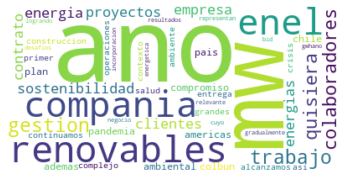



Industria: Servicios Básicos 



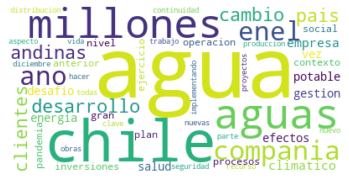



Industria: Financiera 



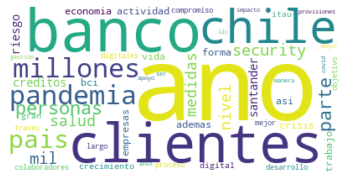



Industria: Manufactura 



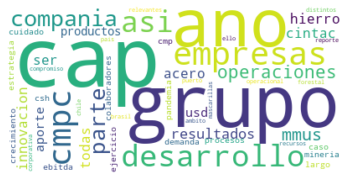



Industria: Bebidas 



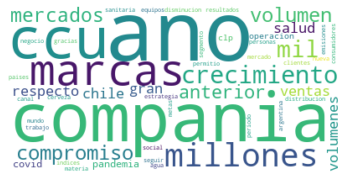



Industria: Comercio 



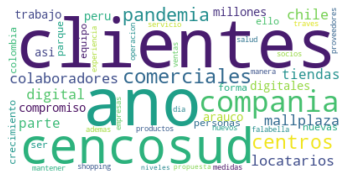



Industria: Tecnología y Transporte 



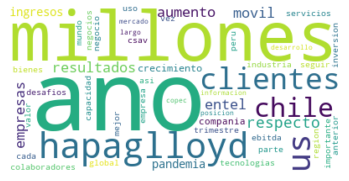

In [22]:
industria = pd.unique(data['industria'])

for ind in industria:
    
    print('Industria:', ind, '\n')
    
    dat = data[data['autor']=='Presidente']
    dat = data[data['industria']==ind]['carta']
    pdat = [preprocess(t) for t in dat]
    
    vect = TfidfVectorizer(max_features=1000, strip_accents='unicode')
    vdat = vect.fit_transform(pdat)
    dfdat = pd.DataFrame(vdat.toarray(), columns=vect.get_feature_names())
    
    freqs = [(word, vdat.getcol(idx).sum()) for word, idx in vect.vocabulary_.items()]
    freqs = dict(freqs)

    w = WordCloud(background_color='white', max_words=50).fit_words(freqs)
    plt.imshow(w, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    print('\n')

En la siguiente celda se separan las cartas por párrafo, de forma que cada texto (la carta) se convierte en una lista de textos más pequeños (los párrafos de la carta). Luego se usa la función *explode*, que  transforma cada elementos de las estas en filas de la base de datos.

De esta manera, cada párrafo se considera como un texto individual, que luego será clasificado por el algoritmo clasificador de sentimiento económico. 

Esto se hace así por varios motivos: 
- (1) los textos de las memorias son principalmente optimistas, por lo que si seopta  por clasificar las cartas completas, todas serían optimistas.
- (2) aunque las cartas sean principalmente optimistas, pueden contener párrafos pesimistas, neutrales y optimistas, por lo que clasificar cada párrafo por separado permite medir el grado de optimismo de cada carta

Por último, la forma de agregar las clasificaciones por texto (por carta) es obtener el porcentaje de párrafos optimistas sobre el total de párrafos. Así, también se logra un tercer objetivo: 
- (3) normalizar por la extensión de las cartas, ya que algunas cartas son mucho más extensas que otras.



In [28]:
#  Se modifica la base de datos para que cada párrafo sea una fila
data['carta'] = data['carta'].apply(lambda x: x.split('\n\n'))
data = data.explode('carta').reset_index()

In [29]:
data.head()

,level_0,index,nombre,industria,cargo,carta,autor
0,0,0,AES Gener,Energía,Presidente del Directorio y Gerente General,La gestión oportuna de los impactos de la pand...,Presidente
1,1,0,AES Gener,Energía,Presidente del Directorio y Gerente General,Quisiera comenzar destacando que a pesar de qu...,Presidente
2,2,0,AES Gener,Energía,Presidente del Directorio y Gerente General,En nuestro objetivo de liderar la transformaci...,Presidente
3,3,0,AES Gener,Energía,Presidente del Directorio y Gerente General,Un hito relevante del Plan de 1.000 MW de proy...,Presidente
4,4,0,AES Gener,Energía,Presidente del Directorio y Gerente General,Los requerimientos que surgieron de este proce...,Presidente


In [31]:
data.to_csv('parrafos.csv', index=False)